# マリオAIチャレンジ 2-2

AIを使ってマリオを全ステージクリアするチャレンジ「Mario Ai Challenge」のステージ2-2 のノートブックです。

プロジェクトページ（GitHub Pages）は以下となります。

https://karaage0703.github.io/mario-ai-challenge/

## 最初に
本チャレンジは、PyTorch公式のチュートリアルの[Train a MARIO-Playing RL Agent](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html)及び、その日本語訳の[PyTorchチュートリアル（日本語翻訳版）](https://yutaroogawa.github.io/pytorch_tutorials_jp/)の「強化学習を用いたマリオの訓練」、その他多くのWeb上の知見を参考に作成しました。

本ノートブックのライセンスは、上記のチュートリアルのライセンスに準じたものになります（詳細は、それぞれのリンク先で確認ください）。

参考にしたサイトは、[GitHubのREFERENCES](https://github.com/karaage0703/mario-ai-challenge/blob/main/REFERENCES.md)にまとめてあります。貴重な知見に心より感謝いたします。

## ハイパーパラメータの設定
主要なハイパーパラメータを最初に設定します。以下のリポジトリを大いに参考にしています。

https://github.com/uvipen/Super-mario-bros-PPO-pytorch

In [1]:
# Env Param
STAGE_NAME = 'SuperMarioBros-2-2-v0'
SKIP_NUMB = 4
STACK_FRAME_NUMB = 16
RESIZE_SIZE = 84

# Model Param
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 100000
# TOTAL_TIMESTEP_NUMB = 5000000
LEARNING_RATE = 0.0001
GAE = 1.0
ENT_COEF = 0.01
N_STEPS = 1024
GAMMA = 0.98
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

## Google Driveとの連携

Google Driveに学習したモデルを保存するために実施します。

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Google Driveにログ用のディレクトリを作成

In [3]:
import os
# LOG_DIR = '/content/drive/MyDrive/gym_mario/'
LOG_DIR = './gym_mario/'
if os.path.exists(LOG_DIR):
    print('log dir exist.')
else:
    print('log dir not exist.')
    os.makedirs(LOG_DIR)

log dir exist.


## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [4]:
!pip install -qq gym-super-mario-bros==7.3.0

その他、必要なライブラリをインストールします。

In [5]:
# !apt -qq update
# !apt install -y -qq xvfb
!pip install -qq pyvirtualdisplay

必要なライブラリをインポートします。

In [6]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
#from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

強化学習に使われる`stable-baselines3`というライブラリをインストールします。ドキュメントは以下参照ください。

https://stable-baselines3.readthedocs.io/en/master/index.html

In [7]:
# Install stable baselines for RL stuff
!pip -qq install stable-baselines3[extra]==1.3.0

`stable-baselines3`と、そのバックエンドに使われている`PyTorch`のバージョンを確認しておきます。

In [8]:
!pip show stable-baselines3
!pip show torch

Name: stable-baselines3
Version: 1.3.0
Summary: Pytorch version of Stable Baselines, implementations of reinforcement learning algorithms.
Home-page: https://github.com/DLR-RM/stable-baselines3
Author: Antonin Raffin
Author-email: antonin.raffin@dlr.de
License: MIT
Location: /home/nob/.local/share/virtualenvs/google_colb-FPNo607z/lib/python3.8/site-packages
Requires: torch, matplotlib, gym, pandas, cloudpickle, numpy
Required-by: 
Name: torch
Version: 1.10.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/nob/.local/share/virtualenvs/google_colb-FPNo607z/lib/python3.8/site-packages
Requires: typing-extensions
Required-by: stable-baselines3


ライブラリをインポートします。

In [9]:
# Import os for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

## AIマリオ環境の構築

AIマリオの環境構築を行います。



### AIマリオ環境初期化と動作確認
最初に一回確認したら、ここは飛ばしても大丈夫です。

In [10]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

In [11]:
MOVEMENT = [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['down']]

In [12]:
# マリオ1-3の環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定
env = JoypadSpace(env, MOVEMENT)
#env = JoypadSpace(env, COMPLEX_MOVEMENT)
#env = JoypadSpace(env, RIGHT_ONLY)

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されていますが、今回は、もう少し自由度を増やした`SIMPLE_MOVEMENT`を採用します。右に進むほど報酬が得られるので、1-1では、そこまで大きな違いは感じられませんでした。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [13]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 2, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 200}


行動`action`の範囲や状態`state`の範囲を確認したい場合は、以下を実行してください。

```python
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

print('action space------------------')
print_spaces(env.action_space)
print('observation space------------------')
print_spaces(env.observation_space)
```

最後に`state`を画像として可視化してみます。

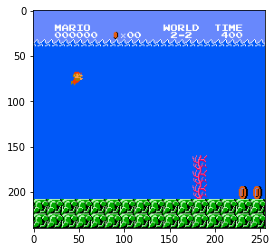

In [14]:
plt.imshow(state)

まさにマリオのプレイ画面ですね。

### AIマリオ環境の前処理
環境に対して、前処理をしていきます。

具体的には、画像のリサイズやグレイスケール化、報酬設計の調整等です。

深層強化学習に限らず、機械学習ではこの前処理が非常に重要となります。

AIマリオ環境のフレームワークとして用いられているOpenAI Gymではカスタムラッパーを使って、環境に前処理を行っていくのがお作法となります。

以下ラッパーの説明をしていきます。

- `SkipFrame`: `gym.Wrapper`を継承し`step()`関数を実装したカスタムのラッパーです。何フレームか同じ行動をとるようにすることで、行動を簡易化しています。
- `GrayScaleObservation`: 画像をグレースケールに変換します。マリオに関しては色はそれほど重要でないと考えられるのでグレースケールを使います。色が重要なゲームでは使えない手法です。
- `ResizeEnv`: 画像をリサイズ（小さく）します。[baselinesのretro_wrappers.py](https://github.com/openai/baselines/blob/master/baselines/common/retro_wrappers.py)を参考にしました。
- `VecFrameStack`: 連続したフレームを1つにまとめるラッパーです。これで、マリオの行動をジャンプや走るといった動きとして認識できるようになります。
- `DummyVecEnv`: 学習のために必要なデータ変換となります。詳細は以下などを参照ください。これを実施すると、`env.step(1)`から`env.step([1])`といった形で、アクションの指定の形式が変わります。[こちら](https://note.com/npaka/n/n5d7d235ad8bc)や[こちら](https://kiyosucyberclub.web.fc2.com/OpenAI_Gym/Gym02-01.html)を参照ください。
- `CustomRewardAndDoneEnv`: 報酬や終了条件をカスタムするラッパーです。[こちら](https://qiita.com/hrs1985/items/871ca5d037d73558bfca)のサイトを参考に、マリオが一機死んだら終了するように変更しています。報酬の調整も可能です。

今回は、多くを独自に実装していますが、以下のようなStable Baselines3用に用意されているWrapperを使っても良いと思います。

https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html

ラッパーのインポートや定義を行います。

In [15]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [16]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """スキップした後のフレームのみを返す"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """行動を繰り返し、報酬を合計する"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # 報酬を蓄積し、同じ行動を繰り返す
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [17]:
class ResizeEnv(gym.ObservationWrapper):
    def __init__(self, env, size):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (size, size, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

### AIマリオ報酬の調整
ポジション移動の与え方を工夫：参考 https://zakopilo.hatenablog.jp/entry/2021/01/30/214806

さらに死んだらだめよと学習させたほうがいいのかもと追記

In [18]:
class CustomRewardAndDoneEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(CustomRewardAndDoneEnv, self).__init__(env)
        self.curr_score = 0
        self.current_x = 40
        self.current_y = 0

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        # Score.
        if info["score"] - self.curr_score > 0:
          reward += 1
          # reward += (info["score"] - self.curr_score) / 10.

        self.curr_score = info["score"]

        # x_pos
        if (info['x_pos'] > self.current_x) & (self.current_x != 0):
            reward += 1
        else:
            reward -= 0.1

        self.current_x = info['x_pos']

        # y_pos
        if (info['y_pos'] > self.current_y) & (self.current_y != 0):
            reward += 0.0
        else:
            reward -= 0.0

        # update.
        self.current_y = info['y_pos']
        self.current_x = info["x_pos"]

        reward /= 1000.

        if info["flag_get"]:
          reward += 5
          done = True

        if info['life'] <= 1:
          reward -= 5

        if info['life'] == 0:
          done = True

        return state, reward, done, info

    def reset(self):
        self.curr_score = 0
        self.current_x = 40
        self.current_y = 0

        return self.env.reset()

環境を再度作成して、Wrapperを適用し、前処理を行います。

In [19]:
env = gym_super_mario_bros.make(STAGE_NAME)
env = JoypadSpace(env, MOVEMENT)
env = CustomRewardAndDoneEnv(env)
env = SkipFrame(env, skip=SKIP_NUMB)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeEnv(env, size=84)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, STACK_FRAME_NUMB, channels_order='last')
# env = StochasticFrameSkip(env, n=4, stickprob=0.25)

## 環境の確認
構築した環境の確認をします。確認が不要な場合はここは飛ばしてOKです。

上記のラッパーを環境に適用すると、最終的な状態（ラップされた結果の状態）は、下図の左側の画像のように4つの連続したグレースケールのフレームを重ね合わせたものになります。

マリオが行動を取るたびに、環境はこのような構造を持つ状態を返します。

この構造は、サイズ`[1, WIDTH, HEIGHT, STACK_FRAME_NUMB]`のテンソルで表されます。

最初の1は`Dummy Vector`の分で`WIDTH, HEIGHT`がダウンサンプリングした画像のサイズ。最後の`STACK_FRAME_NUMB`連続のフレームになります。

実際の中身を見てみましょう

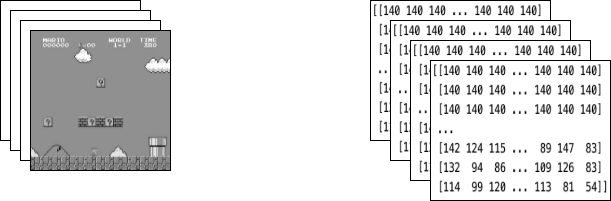

構築した環境を確認します。

In [20]:
env.reset()
state, reward, done, info = env.step([0])

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 16)
reward: [-0.0004]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 2, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 184}]


`STACK_FRAME_NUMB`フレーム分表示します。

In [21]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,STACK_FRAME_NUMB,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

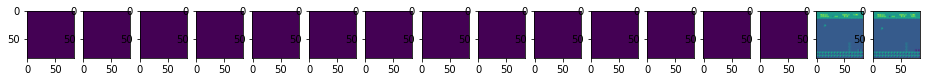

In [22]:
display_all_frame()

In [23]:
print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 16)
reward: [-0.0004]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 2, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 184}]


右ジャンプの操作をして表示してみます。操作に関しては以下コードで対応するアクションを確認しましょう。

- https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py

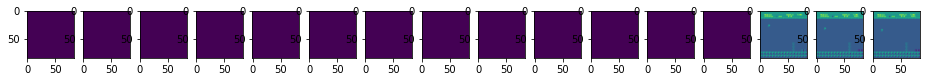

In [24]:
state, reward, done, info = env.step([2])
display_all_frame()

In [25]:
print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 16)
reward: [-0.0004]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 2, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 184}]


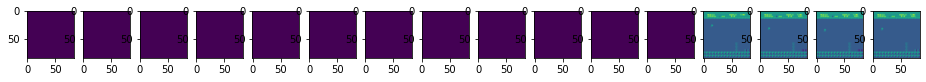

state: (1, 84, 84, 16)
reward: [0.0038]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 2, 'x_pos': 42, 'x_pos_screen': 42, 'y_pos': 189}]


In [26]:
state, reward, done, info = env.step([3])
display_all_frame()

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

## AIマリオの学習

AIモデルの学習をします。学習済みのモデルを使う場合は、ここは飛ばして次のAIマリオのテストまで行ってください。

ログの設定をします。

In [27]:
from pathlib import Path
import datetime
from pytz import timezone
save_dir = Path(LOG_DIR) / datetime.datetime.now(timezone('Asia/Tokyo')).strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
reward_log_path = (save_dir / 'reward_log.csv')

In [28]:
with open(reward_log_path, 'a') as f:
    print('timesteps,reward,best_reward', file=f)

学習のコールバック関数の設定をします。

In [29]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = (save_dir / 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < MAX_TIMESTEP_TEST:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward)

            with open(reward_log_path, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

学習の際、モデルを保存するコールバック関数をセットアップします。

In [30]:
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=save_dir)

AIマリオのモデルを定義します。最初から学習させる場合は以下です。

In [31]:
model = PPO('CnnPolicy', env, verbose=0, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
              batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

途中から学習させる場合は、以下コードを参考にモデルを読み込みましょう

In [63]:
model_path = Path(LOG_DIR) / '2022-01-10T16-29-57/best_model_80000.zip'
print(model_path)

gym_mario/2022-01-10T16-29-57/best_model_80000.zip


In [64]:
model = PPO.load(model_path, env, verbose=0, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
                 batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

AIモデルを学習します。

学習は、xxx万タイムステップ以上、xx時間程度かかりました。

In [65]:
%%time
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)

/home/nob/.local/share/virtualenvs/google_colb-FPNo607z/lib/python3.8/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: ignored

報酬の遷移を可視化します。

<AxesSubplot:xlabel='timesteps'>

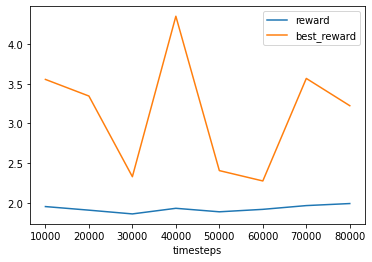

In [66]:
import pandas as pd
reward_log = pd.read_csv(reward_log_path, index_col='timesteps')
reward_log.plot()

最も良かった世代を選択します。

In [67]:
best_epoch = reward_log['reward'].idxmax()
print('best epoch:', best_epoch)

best epoch: 80000


## AIマリオのテスト

AIモデルをテストします。

### AIマリオのモデルの読み込み

#### 学習済みモデルを使用
学習済みモデルを使用する場合は、学習済みモデルを以下コマンドでダウンロードして読み込みます。

読み込んだら、次は飛ばして、AIマリオのプレイを実施してください。

In [68]:
# import gdown
# gdown.download('https://drive.google.com/uc?id=1IMrpPHoUtt3iHZQvW5L7nl4g74Us6dkm', 'mario_1_2.zip', quiet=False)
# model = PPO.load('mario_1_2')

学習済みモデルのリンク

https://drive.google.com/file/d/1IMrpPHoUtt3iHZQvW5L7nl4g74Us6dkm/view?usp=sharing

#### このノートブックで学習したモデルを使用
注：学習済みモデルを使用する場合は、ここは飛ばしてください。

このノートブックで学習したモデルを以下コマンドを実行して読み込みます。平均報酬が一番高い世代のモデルを読み込みます。

In [69]:
best_model_path = os.path.join(save_dir, 'best_model_{}'.format(best_epoch))
model = PPO.load(best_model_path)

In [70]:
best_epoch

80000

#### AIマリオのプレイ
テストした結果を表示すると共に、1番良いときの画像ログデータを保存します。

テスト回数を設定

In [71]:
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

In [72]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info[0]['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

/home/nob/.local/share/virtualenvs/google_colb-FPNo607z/lib/python3.8/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


test episode: 0 reward: 1.8356999841635115 time: 203
test episode: 1 reward: 2.142799982277211 time: 234
test episode: 2 reward: 1.8287999852036592 time: 201
test episode: 3 reward: 1.8062999850371853 time: 266
test episode: 4 reward: 1.8497999844839796 time: 184
test episode: 5 reward: 1.6417999922123272 time: 681
test episode: 6 reward: 1.8238999825844076 time: 190
test episode: 7 reward: 4.37029997058562 time: 1000
test episode: 8 reward: 4.352199958637357 time: 475
test episode: 9 reward: 1.1947999909461942 time: 125
test episode: 10 reward: 1.8596999786095694 time: 188
test episode: 11 reward: 2.2727999843482394 time: 297
test episode: 12 reward: 2.1455999857280403 time: 226
test episode: 13 reward: 2.5389999791805167 time: 374
test episode: 14 reward: 1.8441999814822339 time: 195
test episode: 15 reward: 2.147199981758604 time: 227
test episode: 16 reward: 1.7904999813472386 time: 180
test episode: 17 reward: 1.8390999846160412 time: 196
test episode: 18 reward: 2.195899980870308

`<<< Mario get the flag. GOOOOOAL! >>>`という表示ができたらクリアできています。

クリアできない場合は、複数回プレイして一番良いプレイ動画が保存されます。

実行のたびに結果は変わります。何回か試してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [80]:
SKIP_RATE = 1

画像を間引く処理をします。

In [81]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

In [87]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。

In [88]:
ani.save(save_dir / 'ai_mario.mp4')

動画ファイルをダウンロードします。

In [ ]:
# from google.colab import files
# files.download(save_dir / 'ai_mario.mp4')

GIFアニメ形式で保存します。

In [89]:
import imageio
imageio.mimsave(save_dir / 'ai_mario.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=29)

GIFアニメをダウンロードします。

In [ ]:
# from google.colab import files
# files.download(save_dir / 'ai_mario.gif')

## まとめ

たまたまうまく行ったケース。
だが、土管に入ってくれない・・・。
